In [24]:
import json
import warnings
import massimal.annotation
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
def _collect_all_class_branch_indices(class_branch, class_indices):
    """ Recursively collect all class indices of a given class branch """
    branch_indices = []
    for current_class_name in class_branch:
        if current_class_name in class_indices:
            branch_indices.append(class_indices[current_class_name])  # Include class indices for current level
        else:
            warnings.warn(f'Class name "{current_class_name}" in class_hierarchy not present as key in class_indices.')
        if isinstance(class_branch,dict):                         # If dictionary (nested),
            branch_indices += _collect_all_class_branch_indices(   # recursively collect all "child" indices
                class_branch[current_class_name],class_indices)
    return branch_indices


def _class_tree_search(class_tree,class_indices,class_name):
    """ Recursively get class indices for given class name, with subclasses"""
    group_indices = []

    for current_class_name in class_tree:
        if group_indices: # If we already found the class we're searching for, stop
            break
        if current_class_name == class_name:                # If class name found,
            group_indices.append(class_indices[class_name]) # add index for class, and
            if isinstance(class_tree,dict):                 # if subclasses are present, add them as well
                group_indices += _collect_all_class_branch_indices(class_tree[current_class_name],class_indices)
        else:                                               # If class name not found at this level,
            if isinstance(class_tree,dict):                 # search one level down (if possible)
                group_indices = _class_tree_search(class_tree[current_class_name],class_indices,class_name)
    return group_indices


def class_indices_from_hierarchy(class_hierarchy:dict,class_indices:dict[str,int],class_names:list[str]) -> dict[str,list[int]]:
    """ Group class indices based on class hierarchy 
    
    # Input arguments:
    class_hierarchy: dict
        See massimal_annotation_class_hierarchy.json
        Nested dictionary, with outer levels being more general and inner levels
        being more specific. Lowest level is always a list, but the list can be empty.
    class_indices : dict
        Dictionary (not nested) with class names as keys and class indices 
        (for masks / y-vectors) as values.
    class_names: list
        List of grouped class names. The names must correspond a name in the 
        class hierarchy. If the name is part of a list at the lowest level (leaf),
        the corresponding index is added to the indices for the group.
        If the name is a subcategory (branch), the index for the name and for all
        classes belonging to the subcategory are added to the group indices.
        Class names should not overlap, i.e., one class in the list should not be a 
        subcategory of another class in the list. However, this is not checked
        by the code.

    # Returns:
    grouped_class_indices: dict
        Dictionary with grouped class names as keys and list of corresponding class indices
        as values.

    # Example:
    class_hierarchy = {'Vegetation':{'Grass':[],'Trees':['Oak','Birch']},
        'Rock':['Bedrock','Cobble'],'Buildings':[]}
    class_indices = {'Vegetation':1,'Grass':2,'Trees':3,'Oak':4,'Birch':5,
        'Rock':6,'Bedrock':7,'Cobble':8,'Buildings':9}
    
    With class_names = ['Grass','Trees','Bedrock','Cobble','Buildings'], 
    class_indices_from_hierarchy(class_hierarchy,class_indices,class_names) returns
        {'Grass':[2],'Trees':[3,4,5],'Bedrock':[7],'Cobble':[8],'Buildings':[9]}
    
    """
    grouped_class_indices = {}
    for class_name in class_names:
        # Check if class name is present in class_indices
        if class_name not in class_indices:
            warnings.warn(f'Class name "{class_name}" is not included in class_indices.')
            continue
        
        # Get indices corresponding to class name
        grouped_class_indices[class_name] = set(_class_tree_search(class_hierarchy,class_indices,class_name))
        
        # Issue warning if class name not found in class hierarchy
        if not(grouped_class_indices[class_name]):
            warnings.warn(f'Class name "{class_name}" not found in class_hierarchy')
    return grouped_class_indices

In [56]:
def convert_mask_for_grouped_indices(
    class_mask,
    grouped_classes: dict[str,set[int]]
) -> dict[str,int]:
    """ Convert mask with integer class labels to grouped labels 
    
    # Input arguments: 
    class_mask:
        Integer array with class labels. 
        Value 0 is reserved for background.
    grouped_classes:
        Dictionary with group names (keys) and sets of integers indicating
        integer labels for classes included in the group.

    # Returns:
    group_mask:
        mask with same dimensions as class_mask, but using integer labels
        corresponding to grouped classes.
    group_indices:
        Dictinary with group names (keys) and group integer labels (values)
    """
    group_indices = dict()
    group_mask = np.zeros_like(class_mask)
    
    for i,(group_name, class_indices) in enumerate(grouped_classes.items()):
        group_index = i+1
        group_indices[group_name] = group_index
        for class_index in class_indices:
            class_mask = (class_mask==class_index)
            group_mask[class_mask] = group_index
    return group_mask, group_indices

In [42]:
class_hierarchy = {'Vegetation':{'Grass':[],'Trees':['Oak','Birch']},
    'Rock':['Bedrock','Cobble'],'Buildings':[]}
class_indices = {'Vegetation':1,'Grass':2,'Trees':3,'Oak':4,'Birch':5,
        'Rock':6,'Bedrock':7,'Cobble':8,'Buildings':9,'Test':10}

In [43]:
class_names = ['Grass','Trees','Bedrock','Cobble','Buildings']

In [44]:
_collect_all_class_branch_indices(class_hierarchy,class_indices)

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [45]:
_collect_all_class_branch_indices(class_hierarchy['Vegetation'],class_indices)

[2, 3, 4, 5]

In [46]:
_class_tree_search(class_hierarchy,class_indices,'Rock')

[6, 7, 8]

In [47]:
class_indices_from_hierarchy(class_hierarchy,class_indices,['Grass','Trees','Rock'])

{'Grass': {2}, 'Trees': {3, 4, 5}, 'Rock': {6, 7, 8}}

In [48]:
class_indices_from_hierarchy(class_hierarchy,class_indices,['Grass','Trees','Rock','Dummy'])

C:\Users\mha114\AppData\Local\Temp\ipykernel_29272\2068545469.py:73: UserWarning: Class name "Dummy" is not included in class_indices.
  warnings.warn(f'Class name "{class_name}" is not included in class_indices.')


{'Grass': {2}, 'Trees': {3, 4, 5}, 'Rock': {6, 7, 8}}

In [49]:
class_indices_from_hierarchy(class_hierarchy,class_indices,['Grass','Trees','Rock','Test'])

C:\Users\mha114\AppData\Local\Temp\ipykernel_29272\2068545469.py:81: UserWarning: Class name "Test" not found in class_hierarchy
  warnings.warn(f'Class name "{class_name}" not found in class_hierarchy')


{'Grass': {2}, 'Trees': {3, 4, 5}, 'Rock': {6, 7, 8}, 'Test': set()}

In [50]:
class_indices

{'Vegetation': 1,
 'Grass': 2,
 'Trees': 3,
 'Oak': 4,
 'Birch': 5,
 'Rock': 6,
 'Bedrock': 7,
 'Cobble': 8,
 'Buildings': 9,
 'Test': 10}

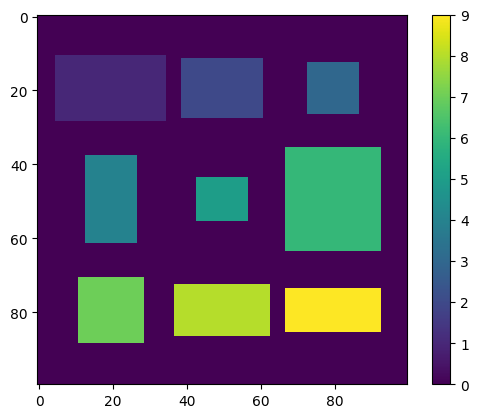

In [60]:
mask = np.zeros(shape=(100,100),dtype=np.uint8)
for i in range(9):
    rc = (i//3)*30 + 20
    cc = (i%3)*30 + 20
    rs = round(random.random()*10) + 5
    cs = round(random.random()*10) + 5
    mask[(rc-rs):(rc+rs),(cc-cs):(cc+cs)] = i+1
plt.imshow(mask)
plt.colorbar()
plt.show()

grouped_class_indices={'Grass': {2}, 'Birch': {5}, 'Rock': {8, 6, 7}}
group_indices={'Grass': 1, 'Birch': 2, 'Rock': 3}


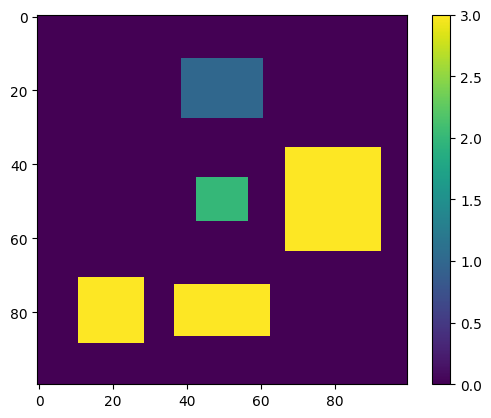

In [61]:
grouped_class_indices = class_indices_from_hierarchy(class_hierarchy,class_indices,['Grass','Birch','Rock'])
grouped_class_mask, group_indices = convert_mask_for_grouped_indices(mask,grouped_class_indices)
print(f'{grouped_class_indices=}')
print(f'{group_indices=}')
plt.imshow(grouped_class_mask)
plt.colorbar()
plt.show()

In [23]:
round(10*random.random())

4

In [12]:
with open('../../annotation/massimal_annotation_class_hierarchy.json','r') as file:
    class_hierarchy = json.load(file)

print(class_hierarchy)

{'Deep water': [], 'Algae': {'Brown algae': {'Kelp': ['Laminaria hyperborea', 'Laminaria digitata', 'Sacchoriza polyides', 'Saccharina latissima', 'Alaria esculenta'], 'Rockweed': {'Rockweed, hydrolittoral': ['Ascophyllum nodosum', 'Fucus vesiculosus', 'Fucus serratus', 'Halidrys siliquosa'], 'Rockweed, geolittoral': ['Fucus spiralis', 'Pelvetia canaliculata']}, 'Brown algae, other': ['Chorda filum', 'Desmarestia aculeata']}, 'Red algae': {'Coralline algae': ['Maerl']}, 'Green algae': [], 'Turf': []}, 'Substrate': {'Rock': ['Bedrock', 'Boulder', 'Cobble', 'Gravel'], 'Sediment': ['Sand', 'Mud']}, 'Animals': {'Mussels': ['Mytilus edilus']}, 'Human activity': ['Trawl track']}


In [13]:
class_indices = massimal.annotation.read_hasty_metadata('example_label_classes.json')
print(class_indices)

{'Deep water': 1, 'Substrate': 2, 'Rock': 3, 'Bedrock': 4, 'Boulder': 5, 'Cobble': 6, 'Gravel': 7, 'Sediment': 8, 'Sand': 9, 'Mud': 10, 'Algae': 11, 'Turf': 12, 'Brown algae': 13, 'Kelp': 14, 'Rockweed': 15, 'Rockweed, hydrolitteral': 16, 'Rockweed, geolitteral': 17, 'Other brown algae': 18, 'Coralline algae': 19, 'Maerl': 20, 'Green algae': 21, 'Red algae': 22, 'Saccharina latissima': 23, 'Alaria esculenta': 24, 'Fucus vesiculosus': 25, 'Fucus serratus': 26, 'Fucus spiralis': 27, 'Pelvetia canaliculata': 28, 'Halidrys siliquosa': 29, 'Desmarestia aculeata': 30, 'Chorda filum': 31, 'Animals': 32, 'Mussels': 33, 'Mytilus edilus': 34, 'Laminaria hyperborea': 35, 'Laminaria digitata': 36, 'Trawl track': 37, 'Sacchoriza polyides': 38}


In [14]:
class_indices_from_hierarchy(class_hierarchy,class_indices,['Kelp','Rockweed'])

C:\Users\mha114\AppData\Local\Temp\ipykernel_29272\2068545469.py:8: UserWarning: Class name "Rockweed, hydrolittoral" in class_hierarchy not present as key in class_indices.
  warnings.warn(f'Class name "{current_class_name}" in class_hierarchy not present as key in class_indices.')
C:\Users\mha114\AppData\Local\Temp\ipykernel_29272\2068545469.py:8: UserWarning: Class name "Ascophyllum nodosum" in class_hierarchy not present as key in class_indices.
  warnings.warn(f'Class name "{current_class_name}" in class_hierarchy not present as key in class_indices.')
C:\Users\mha114\AppData\Local\Temp\ipykernel_29272\2068545469.py:8: UserWarning: Class name "Rockweed, geolittoral" in class_hierarchy not present as key in class_indices.
  warnings.warn(f'Class name "{current_class_name}" in class_hierarchy not present as key in class_indices.')


{'Kelp': {14, 23, 24, 35, 36, 38}, 'Rockweed': {15, 25, 26, 27, 28, 29}}